# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


# create more summaries on columns
# create maps use geopandas

The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '', regex=True).str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [6]:
sa_vouchers_scores[sa_vouchers_scores["Participant_LGA"].str.contains('ADELAIDE PLAINS') == True]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
6954,1006955,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,30/3/17 0:46,2017,NaN,NaN,NaN,NaN,NaN
6955,1006956,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Mallala Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,14/9/15 5:20,2015,NaN,NaN,NaN,NaN,NaN
6956,1006957,BARABBA,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/3/17 0:37,2017,NaN,NaN,NaN,NaN,NaN
6957,1006960,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Hamley Bridge Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,28/8/15 2:28,2015,NaN,NaN,NaN,NaN,NaN
6958,1006960,BARABBA,Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123703,1123704,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016,NaN,NaN,NaN,NaN,NaN
123704,1123705,WINDSOR,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/5/17 7:58,2017,NaN,NaN,NaN,NaN,NaN
123705,1123706,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Female,50,Long Plains Netball Club,Netball,ADELAIDE PLAINS,GOYDER,25/2/16 2:23,2015,NaN,NaN,NaN,NaN,NaN
123706,1123707,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,28/4/17 5:04,2017,NaN,NaN,NaN,NaN,NaN


### Description of voucher data:

- __Participant_ATSI_Indicator:__ Categorises the participant as identifying with aboriginal or Torres Strait Island heritage (ATSI), or not (Not ATSI)
- __Participant_CALD_Indicator:__ Categorises the participant as identifying with a non-Australian cultural background (CALD) or not (Not CALD) 
- __Voucher_Sport:__ Description of the activity undertaken using a sport voucher

### Description of seifa data:

__Low score indicates most disadvantaged.__

- __IRSAD:__ The Index of Relative Socio-economic Advantage and Disadvantage (IRSAD) summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures.
- __IRSD:__ The Index of Relative Socio-economic Disadvantage (IRSD) is a general socio-economic index that summarises a range of information about the economic and social conditions of people and households within an area.
- __IER:__ The Index of Economic Resources (IER) focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth. This index excludes education and occupation variables because they are not direct measures of economic resources. It also misses some assets such as savings or equities which, although relevant, could not be included because this information was not collected in the 2011 Census.
- __IEO:__ The Index of Education and Occupation (IEO) is designed to reflect the educational and occupational level of communities.

### 1. Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

#### 1.1 By LGA

In [7]:
# group by LGA
LGA_vouchers = sa_vouchers_scores.groupby(
    "Participant_LGA")["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA_vouchers

,Participant_LGA,Voucher_Count
0,ADELAIDE,302
1,ADELAIDE HILLS,4756
2,ADELAIDE PLAINS,899
3,ALEXANDRINA,2979
4,BAROSSA,2874
...,...,...
64,WEST TORRENS,2844
65,WHYALLA,2488
66,WUDINNA,267
67,YANKALILLA,443


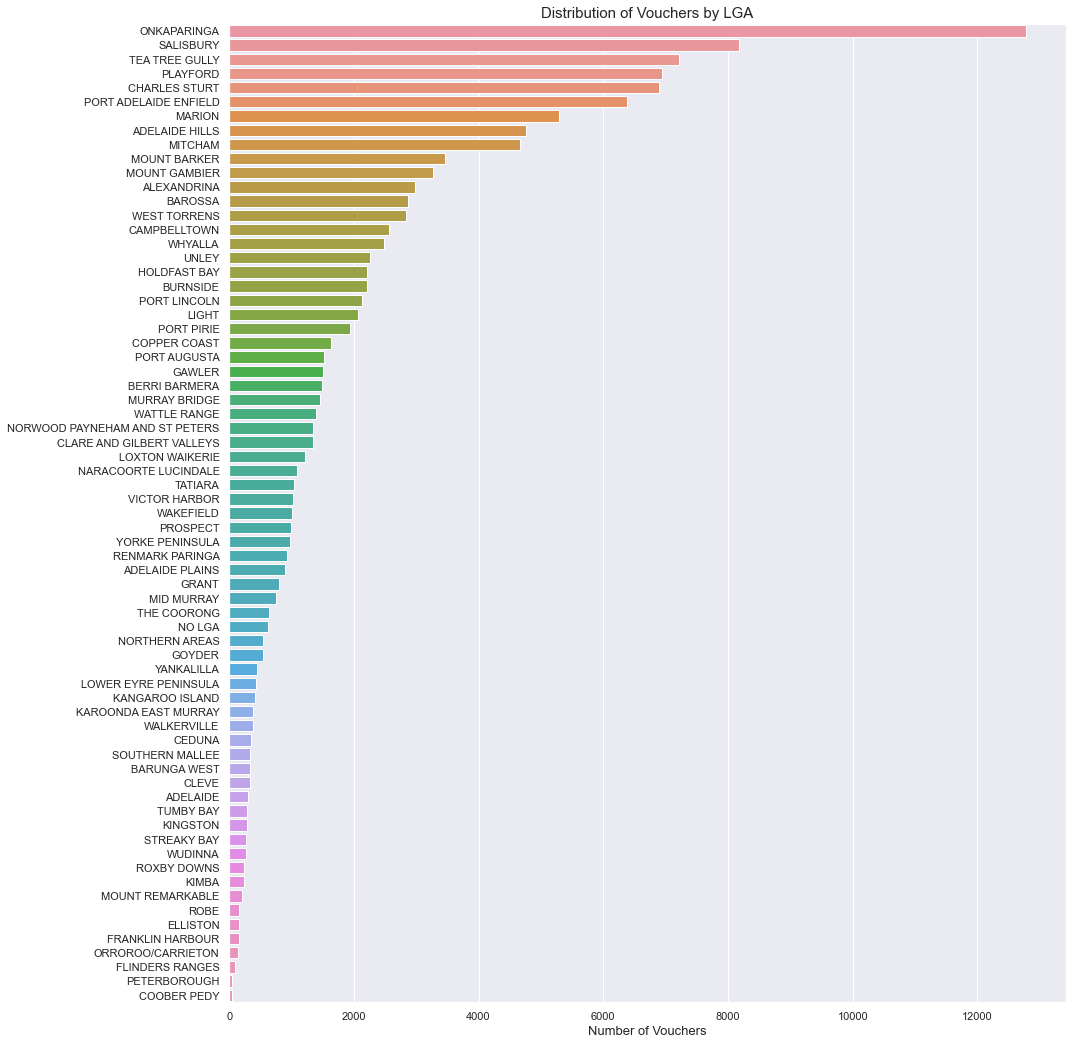

In [8]:
# show distribution of vouchers by LGA
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 18))
LGA_vouchers = LGA_vouchers.sort_values("Voucher_Count", ascending = False)
sns.barplot(data=LGA_vouchers, x="Voucher_Count", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

It can clearly be seen that there is a highly uneven distribution between different areas. In the following it will be checked whether uneven population distribution might be the reason. If yes, voucher count should be calculated per x amount of people.

In [9]:
# extract LGAs and respective population from main dataframe
population = sa_vouchers_scores.drop_duplicates("Participant_LGA")[["Participant_LGA", "Population"]]
population.sort_values(by='Participant_LGA')

,Participant_LGA,Population
829,ADELAIDE,19606.0
1275,ADELAIDE HILLS,38601.0
6954,ADELAIDE PLAINS,NaN
4122,ALEXANDRINA,23693.0
3093,BAROSSA,22174.0
...,...,...
5287,WEST TORRENS,54932.0
71759,WHYALLA,22070.0
51891,WUDINNA,1256.0
6436,YANKALILLA,4406.0


In [10]:
population[population["Participant_LGA"] == "ADELAIDE PLAINS"]

,Participant_LGA,Population
6954,ADELAIDE PLAINS,NaN


In [11]:
# Concatenate to single dataframe
LGA_vouchers.sort_values(by='Participant_LGA')
pop_lga = pd.merge(population, LGA_vouchers, 'inner', 'Participant_LGA')
pop_lga

,Participant_LGA,Population,Voucher_Count
0,ONKAPARINGA,159517.0,12782
1,ADELAIDE,19606.0,302
2,YORKE PENINSULA,11046.0,977
3,CHARLES STURT,104922.0,6897
4,PORT ADELAIDE ENFIELD,112797.0,6384
...,...,...,...
64,MOUNT GAMBIER,25254.0,3271
65,WHYALLA,22070.0,2488
66,PETERBOROUGH,1733.0,45
67,PORT LINCOLN,14083.0,2125


In [12]:
pop_lga[pop_lga["Participant_LGA"] == "ADELAIDE PLAINS"]

,Participant_LGA,Population,Voucher_Count
31,ADELAIDE PLAINS,NaN,899


In [13]:
# show correlation between population and number of vouchers
pop_lga.corr()

,Population,Voucher_Count
Population,1.000000,0.909829
Voucher_Count,0.909829,1.000000


Since there is a high correlation, this indicates that the number of vouchers per area should be considered relatively to population size for comparison. <br >
__Note:__ In the pop_lga dataframe it can be seen that there is a LGA with population size zero but 899 vouchers redeemed. Since this should not be the case, further analysis in this regard will be done in the following before showing the distribution of number of vouchers per LGA relative to population size.

In [14]:
# check spelling of these LGAs in census data
seifa[seifa["LGA"].str.contains('ADELAIDE PLAINS') == True]

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA


In [15]:
# check spelling of these LGAs in voucher data
sa_vouchers[sa_vouchers["Participant_LGA"].str.contains('ADELAIDE PLAINS') == True]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
6954,1006955,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,30/3/17 0:46,2017
6955,1006956,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Mallala Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,14/9/15 5:20,2015
6956,1006957,BARABBA,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/3/17 0:37,2017
6957,1006960,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Hamley Bridge Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,28/8/15 2:28,2015
6958,1006960,BARABBA,Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123703,1123704,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016
123704,1123705,WINDSOR,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/5/17 7:58,2017
123705,1123706,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Female,50,Long Plains Netball Club,Netball,ADELAIDE PLAINS,GOYDER,25/2/16 2:23,2015
123706,1123707,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,28/4/17 5:04,2017


In [16]:
# remove records where values for population are missing
pop_lga_clean = pop_lga.dropna()
pop_lga_clean

,Participant_LGA,Population,Voucher_Count
0,ONKAPARINGA,159517.0,12782
1,ADELAIDE,19606.0,302
2,YORKE PENINSULA,11046.0,977
3,CHARLES STURT,104922.0,6897
4,PORT ADELAIDE ENFIELD,112797.0,6384
...,...,...,...
64,MOUNT GAMBIER,25254.0,3271
65,WHYALLA,22070.0,2488
66,PETERBOROUGH,1733.0,45
67,PORT LINCOLN,14083.0,2125


In [17]:
# create column of number of vouchers per thousand people in each LGA
pop_lga_clean["Voucher_Per_100"] = round(
    (pop_lga_clean["Voucher_Count"] / pop_lga_clean["Population"]) * 100, 2)
pop_lga_clean = pop_lga_clean.sort_values("Voucher_Per_100", ascending = False)
pop_lga_clean

<ipython-input-17-c0464c907dde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lga_clean["Voucher_Per_100"] = round(


,Participant_LGA,Population,Voucher_Count,Voucher_Per_100
27,KAROONDA EAST MURRAY,1035.0,388,37.49
46,KIMBA,1087.0,232,21.34
63,WUDINNA,1256.0,267,21.26
18,CLEVE,1729.0,329,19.03
60,SOUTHERN MALLEE,2097.0,342,16.31
...,...,...,...,...
21,CAMPBELLTOWN,97060.0,2567,2.64
66,PETERBOROUGH,1733.0,45,2.60
56,COOBER PEDY,1694.0,39,2.30
1,ADELAIDE,19606.0,302,1.54


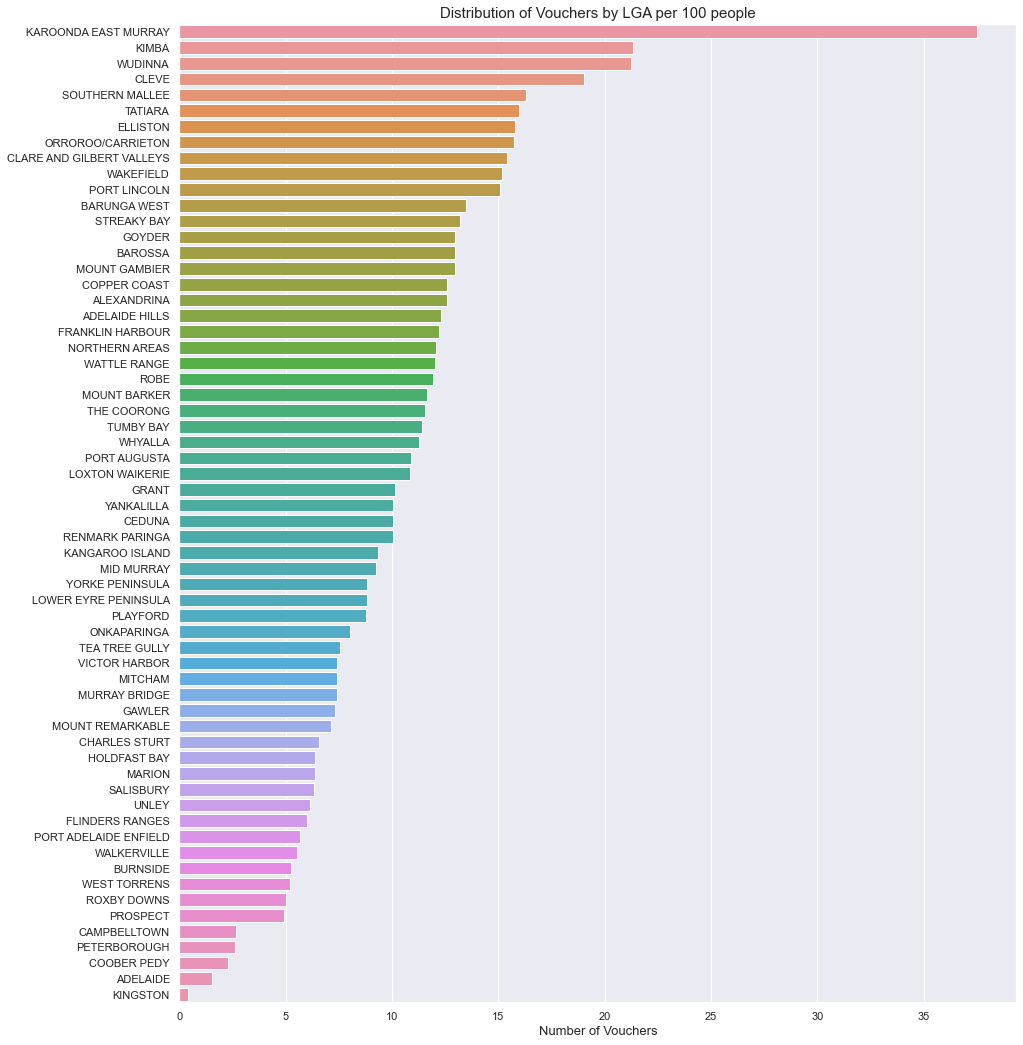

In [18]:
plt.figure(figsize=(15, 18))
sns.barplot(data=pop_lga_clean, x="Voucher_Per_100", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA per 100 people", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

### Findings of LGA analysis:


#### 1.2 By Sports

In [19]:
# group by sports
sports_vouchers = sa_vouchers_scores.groupby(
    "Voucher_Sport")["Voucher_Sport"].count().to_frame(name = 'Voucher_Count').reset_index()
sports_vouchers = sports_vouchers.sort_values(by='Voucher_Count', ascending= False)
sports_vouchers.head(10)

,Voucher_Sport,Voucher_Count
2,Australian Rules,47224
27,Netball,24017
15,Football (Soccer),15775
17,Gymnastics,9823
6,Basketball,6016
1,Athletics,4518
44,Tennis,3742
18,Hockey,3026
8,Calisthenics,2522
9,Cricket,1875


In [20]:
# calculate proportion of vouchers per sport, then show where 80% of vouchers are redeemed
sports_vouchers["Voucher_prop"] = round(sports_vouchers["Voucher_Count"]/sum(sports_vouchers["Voucher_Count"])*100, 2)
sports_vouchers.head(10)
    

,Voucher_Sport,Voucher_Count,Voucher_prop
2,Australian Rules,47224,37.03
27,Netball,24017,18.83
15,Football (Soccer),15775,12.37
17,Gymnastics,9823,7.70
6,Basketball,6016,4.72
1,Athletics,4518,3.54
44,Tennis,3742,2.93
18,Hockey,3026,2.37
8,Calisthenics,2522,1.98
9,Cricket,1875,1.47


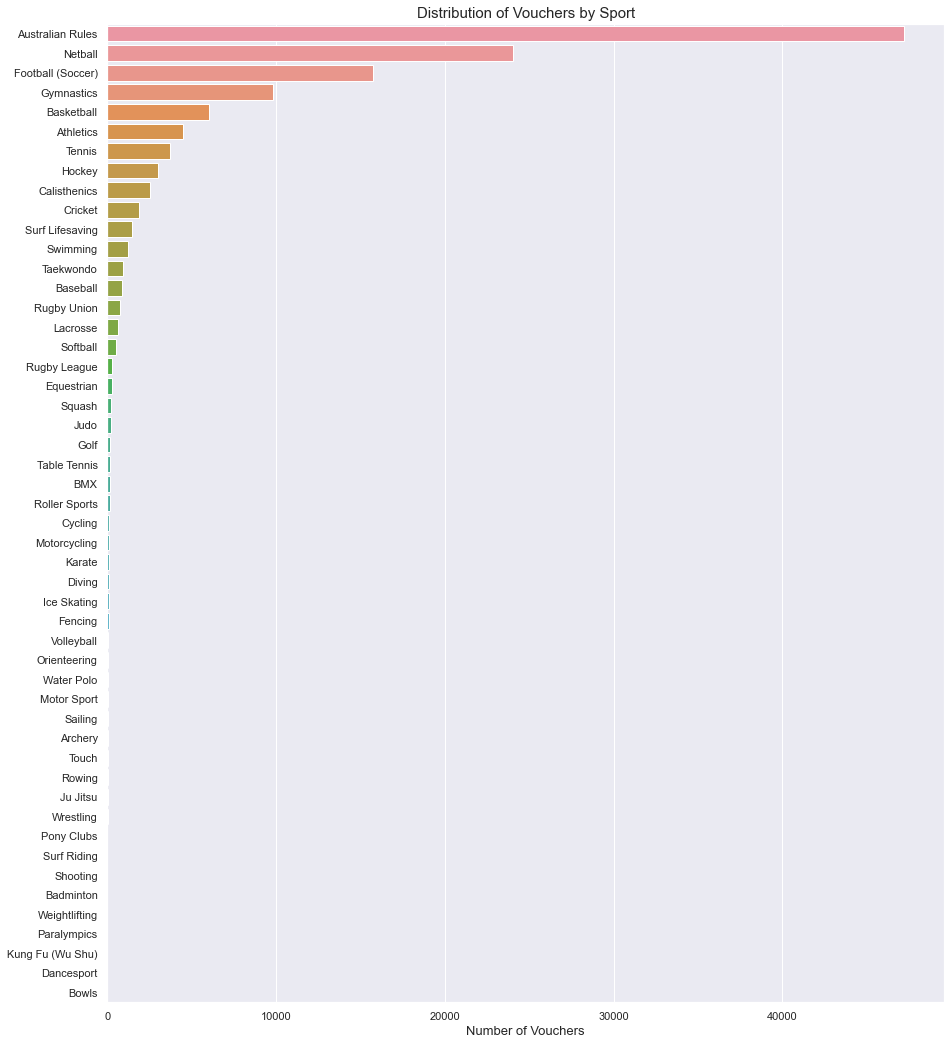

In [21]:
# show distribution of vouchers by sports
plt.figure(figsize=(15, 18))
sns.barplot(data=sports_vouchers, x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [22]:
# show sports where less than 50 vouchers have been redeemed
sports_vouchers[sports_vouchers["Voucher_Count"] < 50]

,Voucher_Sport,Voucher_Count,Voucher_prop
47,Water Polo,48,0.04
25,Motor Sport,45,0.04
35,Sailing,40,0.03
0,Archery,34,0.03
45,Touch,23,0.02
32,Rowing,22,0.02
20,Ju Jitsu,22,0.02
49,Wrestling,19,0.01
30,Pony Clubs,17,0.01
40,Surf Riding,15,0.01


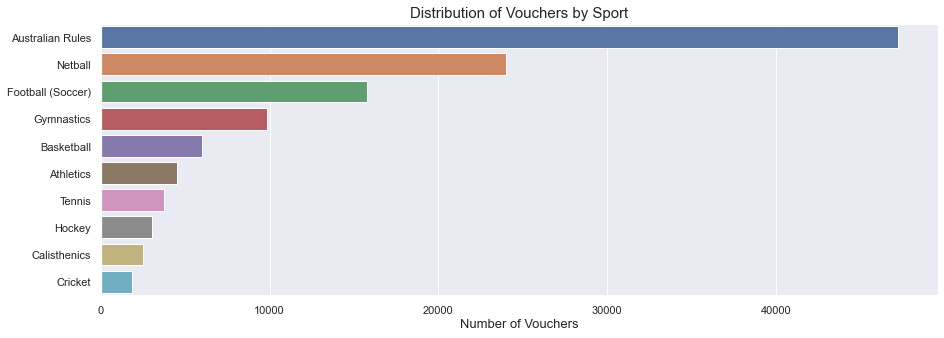

In [23]:
# show distribution of vouchers by more relevant sports
plt.figure(figsize=(15, 5))
sns.barplot(data=sports_vouchers.nlargest(10, "Voucher_Count"), x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [24]:
hue=sports

NameError: name 'sports' is not defined

In [ ]:
# group by participants LGA and sports
LGA__sports_vouchers = sa_vouchers_scores.groupby(
    ["Participant_LGA", "Voucher_Sport"])["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA__sports_vouchers

In [ ]:
sns.barplot

In [ ]:
# select only 10 largest
LGA_vouchers_top = LGA_vouchers["Participant_ID"].nlargest(20)
LGA_vouchers_top

In [ ]:
# show distribution for largest

sns.countplot(y=LGA_vouchers_top10["Participants_LGA"], data=LGA_vouchers_top10)

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [ ]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

In [ ]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()